# Restaurant Visitor Forecasting

### 1. Data Preprocessing

In [82]:
import pandas as pd

air_visit = pd.read_csv('data/air_visit_data.csv')
air_reserve = pd.read_csv('data/air_reserve.csv')
hpg_reserve = pd.read_csv('data/hpg_reserve.csv')
air_store_info = pd.read_csv('data/air_store_info.csv')
hpg_store_info = pd.read_csv('data/hpg_store_info.csv')
store_id_relation = pd.read_csv('data/store_id_relation.csv')
date_info = pd.read_csv('data/date_info.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

Converting to datetime format

In [83]:
for df in [air_reserve, hpg_reserve]:
    df['visit_datetime'] = pd.to_datetime(df['visit_datetime']).dt.date
    df['reserve_datetime'] = pd.to_datetime(df['reserve_datetime']).dt.date

air_visit['visit_date'] = pd.to_datetime(air_visit['visit_date']).dt.date
date_info['calendar_date'] = pd.to_datetime(date_info['calendar_date']).dt.date

Aggregating Reservation Data
- Total reservations per day
- Average reservation lead time (gap between reservation and visit)

In [84]:
air_reserve['reserve_lead_time'] = (
    pd.to_datetime(air_reserve['visit_datetime']) - 
    pd.to_datetime(air_reserve['reserve_datetime'])
).dt.days

air_agg = air_reserve.groupby(['air_store_id', 'visit_datetime']).agg({
    'reserve_visitors': 'sum',
    'reserve_lead_time': 'mean'
}).reset_index().rename(columns={
    'visit_datetime': 'visit_date',
    'reserve_visitors': 'air_reserve_visitors',
    'reserve_lead_time': 'air_reserve_lead_time'
})

In [85]:
hpg_reserve = hpg_reserve.merge(store_id_relation, on='hpg_store_id', how='inner')

hpg_reserve['reserve_lead_time'] = (
    pd.to_datetime(hpg_reserve['visit_datetime']) - 
    pd.to_datetime(hpg_reserve['reserve_datetime'])
).dt.days

hpg_agg = hpg_reserve.groupby(['air_store_id', 'visit_datetime']).agg({
    'reserve_visitors': 'sum',
    'reserve_lead_time': 'mean'
}).reset_index().rename(columns={
    'visit_datetime': 'visit_date',
    'reserve_visitors': 'hpg_reserve_visitors',
    'reserve_lead_time': 'hpg_reserve_lead_time'
})

Creating the modeling base table

In [86]:
# Merge visitor data with reservation features
full_df = air_visit.merge(air_agg, on=['air_store_id', 'visit_date'], how='left')
full_df = full_df.merge(hpg_agg, on=['air_store_id', 'visit_date'], how='left')

# Merge with restaurant metadata
full_df = full_df.merge(air_store_info, on='air_store_id', how='left')

# Merge with calendar features
date_info = date_info.rename(columns={'calendar_date': 'visit_date'})
full_df = full_df.merge(date_info, on='visit_date', how='left')

# Add weekday and weekend features
full_df['day_of_week'] = pd.to_datetime(full_df['visit_date']).dt.dayofweek
full_df['is_weekend'] = full_df['day_of_week'].isin([5, 6]).astype(int)

In [87]:
full_df.head()

,air_store_id,visit_date,visitors,air_reserve_visitors,air_reserve_lead_time,hpg_reserve_visitors,hpg_reserve_lead_time,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg,is_weekend
0,air_ba937bf13d40fb24,2016-01-13,25,NaN,NaN,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2,0,0
1,air_ba937bf13d40fb24,2016-01-14,32,NaN,NaN,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,3,0,0
2,air_ba937bf13d40fb24,2016-01-15,29,NaN,NaN,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,4,0,0
3,air_ba937bf13d40fb24,2016-01-16,22,NaN,NaN,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,5,0,1
4,air_ba937bf13d40fb24,2016-01-18,6,NaN,NaN,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0,0,0


### 2. Lag + Rolling Features

In [88]:
full_df = full_df.sort_values(['air_store_id', 'visit_date'])

In [89]:
# Set number of days to lag
lag_days = [1, 7, 14]

for lag in lag_days:
    full_df[f'visitors_lag_{lag}'] = (
        full_df
        .groupby('air_store_id')['visitors']
        .shift(lag)
    )

In [90]:
rolling_windows = [3, 7, 14]

for window in rolling_windows:
    full_df[f'visitors_roll_mean_{window}'] = (
        full_df
        .groupby('air_store_id')['visitors']
        .shift(1)  # ensure that we're not using today’s visitor count to predict itself (no leakage)
        .rolling(window)
        .mean()
        .reset_index(0, drop=True)
    )
    
    full_df[f'visitors_roll_std_{window}'] = (
        full_df
        .groupby('air_store_id')['visitors']
        .shift(1)
        .rolling(window)
        .std()
        .reset_index(0, drop=True)
    )

In [91]:
full_df.head()

,air_store_id,visit_date,visitors,air_reserve_visitors,air_reserve_lead_time,hpg_reserve_visitors,hpg_reserve_lead_time,air_genre_name,air_area_name,latitude,...,is_weekend,visitors_lag_1,visitors_lag_7,visitors_lag_14,visitors_roll_mean_3,visitors_roll_std_3,visitors_roll_mean_7,visitors_roll_std_7,visitors_roll_mean_14,visitors_roll_std_14
87534,air_00a91d42b08b08d9,2016-07-01,35,NaN,NaN,1.0,1.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,NaN,NaN,NaN,49.000000,6.082763,47.285714,7.994045,52.428571,38.679580
87535,air_00a91d42b08b08d9,2016-07-02,9,NaN,NaN,NaN,NaN,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,1,35.0,NaN,NaN,49.333333,5.859465,48.571429,6.900656,53.214286,38.431114
87536,air_00a91d42b08b08d9,2016-07-04,20,NaN,NaN,NaN,NaN,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,9.0,NaN,NaN,37.666667,24.378953,42.000000,15.362291,41.000000,14.277470
87537,air_00a91d42b08b08d9,2016-07-05,25,NaN,NaN,NaN,NaN,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,20.0,NaN,NaN,36.000000,22.605309,44.000000,15.513435,42.571429,14.064217
87538,air_00a91d42b08b08d9,2016-07-06,29,NaN,NaN,7.0,12.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,25.0,NaN,NaN,38.333333,24.583192,44.142857,15.614401,45.357143,11.875036


### 3. LightGBM Model Setup (Backbone Model)

In [92]:
full_df = full_df[~full_df['visitors'].isna()] # Drop rows with missing target (if any)

In [93]:
target = 'visitors'

# Drop columns we won't use or that leak information
drop_cols = ['visit_date', 'visitors']  # we keep 'air_store_id' for now, might encode

# Get all feature columns
features = [col for col in full_df.columns if col not in drop_cols]

In [94]:
from sklearn.preprocessing import LabelEncoder

# Label encode categorical columns

for col in ['air_store_id', 'air_genre_name', 'air_area_name']:
    le = LabelEncoder()
    full_df[col] = le.fit_transform(full_df[col].astype(str))

categorical_features = ['air_store_id', 'air_genre_name', 'air_area_name']

Why Use 2017-03-01 as the cutoff_date?

The data covers:
- Training range: from 2016-01-01 to 2017-04-22
- Test range: late April 2017 to May 2017 (includes Golden Week)

I picked a validation window that:
- Mimics the real test period (late April–May)
- Gives at least 1–2 months of “unseen future” for validation
- Leaves enough history to train LightGBM (over a year of training data)

2017-03-01 gives ~1.5 months of validation data from March to April 22

In [95]:
# Train-Test Split (Time-based)
# Use last N days as validation set
full_df['visit_date'] = pd.to_datetime(full_df['visit_date'])  # Convert to Timestamp

cutoff_date = pd.to_datetime('2017-03-01')
train_df = full_df[full_df['visit_date'] < cutoff_date]
valid_df = full_df[full_df['visit_date'] >= cutoff_date]

In [96]:
import lightgbm as lgb

train_set = lgb.Dataset(train_df[features], label=train_df[target], categorical_feature=categorical_features)
valid_set = lgb.Dataset(valid_df[features], label=valid_df[target], categorical_feature=categorical_features)

In [97]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1
}

lgb_model = lgb.train(
    params,
    train_set,
    valid_sets=[train_set, valid_set],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 10.4999	valid_1's rmse: 12.7305
[200]	training's rmse: 10.0871	valid_1's rmse: 12.5096
[300]	training's rmse: 9.85345	valid_1's rmse: 12.4725
Early stopping, best iteration is:
[304]	training's rmse: 9.84606	valid_1's rmse: 12.4695


| Metric    | Best For |
| -------- | ------- |
| RMSE  | General-purpose numeric prediction    |
| RMSLE  | Counts, skewed distributions, penalizing underestimates more than overestimates (better for demand forecasting)    |

In [98]:
from sklearn.metrics import mean_squared_log_error
import numpy as np

y_true = valid_df[target]
y_pred = lgb_model.predict(valid_df[features])
y_pred = np.clip(y_pred, 0, None)  # No negative visitor predictions

rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
print(f"Validation RMSLE: {rmsle:.4f}")

Validation RMSLE: 0.5374


Plotting Feature Importance

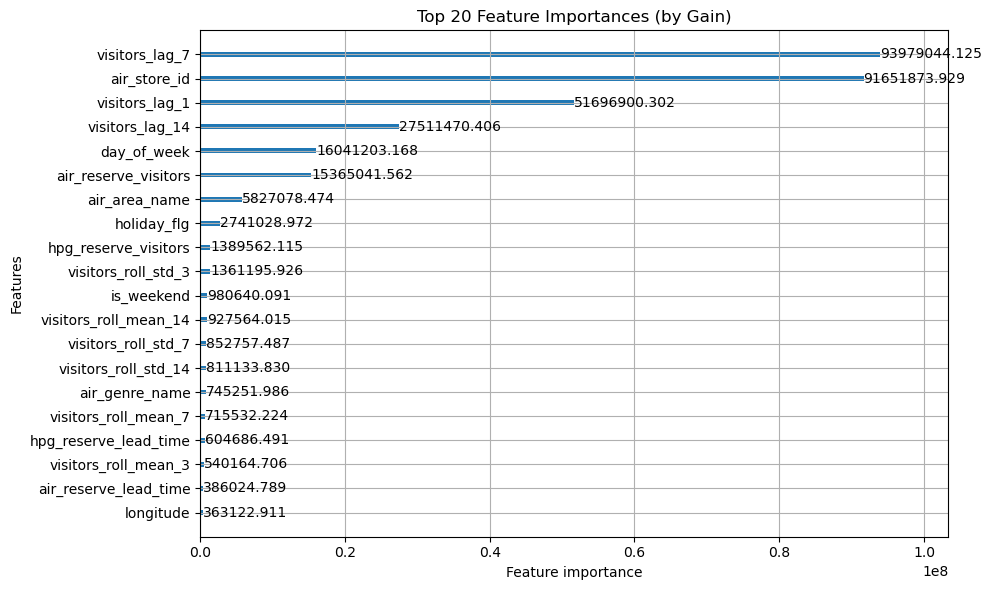

In [99]:
import matplotlib.pyplot as plt
lgb.plot_importance(lgb_model, max_num_features=20, importance_type='gain', figsize=(10, 6))
plt.title("Top 20 Feature Importances (by Gain)")
plt.tight_layout()
plt.show()

### 4. Integrating Prophet

In [100]:
from prophet import Prophet

In [101]:
# Count non-NaN visitors per store
store_counts = full_df.groupby('air_store_id')['visitors'].apply(lambda x: x.notna().sum()).sort_values(ascending=False)

# Pick a store with at least 50 non-NaN entries
valid_store_id = store_counts[store_counts >= 50].index[0]
print(f"Using store: {valid_store_id}")

Using store: 274


In [102]:
holidays = date_info[date_info['holiday_flg'] == 1][['visit_date']].rename(columns={
    'visit_date': 'ds'
})
holidays['holiday'] = 'japan_holiday'

In [103]:
store_df = full_df[(full_df['air_store_id'] == valid_store_id) & (full_df['visitors'].notnull())].copy()

prophet_df = store_df[['visit_date', 'visitors']].rename(columns={
    'visit_date': 'ds',
    'visitors': 'y'
})

In [104]:
print(prophet_df.head())
print(prophet_df['y'].notna().sum(), "non-NaN values in 'y'")

               ds   y
158602 2016-01-02  24
158603 2016-01-03  49
158604 2016-01-04  10
158605 2016-01-05   2
158606 2016-01-06   9
477 non-NaN values in 'y'


In [105]:
m = Prophet(
    holidays=holidays,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

m.fit(prophet_df)

20:16:24 - cmdstanpy - INFO - Chain [1] start processing
20:16:24 - cmdstanpy - INFO - Chain [1] done processing


In [106]:
# Get number of future days to forecast (from your validation set)
forecast_horizon = valid_df[valid_df['air_store_id'] == valid_store_id]['visit_date'].nunique()

# Create future dataframe for Prophet
future = m.make_future_dataframe(periods=forecast_horizon)

# Generate forecast
forecast = m.predict(future)

In [107]:
# Merge Prophet forecast with actual validation data
store_forecast = forecast[['ds', 'yhat']].merge(
    valid_df[valid_df['air_store_id'] == valid_store_id][['visit_date', 'visitors']],
    left_on='ds',
    right_on='visit_date',
    how='inner'
)

In [108]:
from sklearn.metrics import mean_squared_log_error
import numpy as np

y_true = store_forecast['visitors']
y_pred = np.clip(store_forecast['yhat'], 0, None)  # Remove negative predictions

prophet_rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
print(f"Prophet RMSLE for {valid_store_id}: {prophet_rmsle:.4f}")

Prophet RMSLE for 274: 0.4460


### 5. Testing ARIMA

In [109]:
from statsmodels.tsa.arima.model import ARIMA

# Use the same store
arima_df = full_df[(full_df['air_store_id'] == valid_store_id)].copy()
arima_df = arima_df[['visit_date', 'visitors']].dropna()
arima_df = arima_df.set_index('visit_date').asfreq('D')  # Ensure daily frequency

In [110]:
arima_df['visitors'] = arima_df['visitors'].fillna(0)

In [111]:
arima_model = ARIMA(arima_df['visitors'], order=(5,1,0))
arima_model_fit = arima_model.fit()

In [112]:
n_days = valid_df[valid_df['air_store_id'] == valid_store_id]['visit_date'].nunique()
arima_forecast = arima_model_fit.forecast(steps=n_days)

In [113]:
actual = valid_df[valid_df['air_store_id'] == valid_store_id][['visit_date', 'visitors']].copy().reset_index(drop=True)
actual['arima_pred'] = np.clip(arima_forecast.values, 0, None)

In [114]:
from sklearn.metrics import mean_squared_log_error

arima_rmsle = np.sqrt(mean_squared_log_error(actual['visitors'], actual['arima_pred']))
print(f"ARIMA RMSLE for {valid_store_id}: {arima_rmsle:.4f}")

ARIMA RMSLE for 274: 0.6662


| Model    | RMSLE | Interpretation |
| -------- | ------- |  ------- |
| Prophet  | 0.4460    | Captures holiday + seasonal patterns effectively|
| RMSLE  | 0.6662  |  Struggles to generalize — likely overfits short-term noise  |

## 6. LightGBM + Prophet Ensemble

In [115]:
valid_df.head()

,air_store_id,visit_date,visitors,air_reserve_visitors,air_reserve_lead_time,hpg_reserve_visitors,hpg_reserve_lead_time,air_genre_name,air_area_name,latitude,...,is_weekend,visitors_lag_1,visitors_lag_7,visitors_lag_14,visitors_roll_mean_3,visitors_roll_std_3,visitors_roll_mean_7,visitors_roll_std_7,visitors_roll_mean_14,visitors_roll_std_14
87722,0,2017-03-01,17,3.0,11.0,4.0,11.0,6,44,35.694003,...,0,19.0,36.0,24.0,30.666667,6.658328,25.000000,8.755950,29.500000,8.899006
87723,0,2017-03-02,33,NaN,NaN,2.0,1.0,6,44,35.694003,...,0,17.0,33.0,41.0,34.666667,11.503623,29.857143,9.719886,29.928571,9.563265
87724,0,2017-03-03,29,NaN,NaN,NaN,NaN,6,44,35.694003,...,0,33.0,40.0,52.0,42.333333,6.350853,34.142857,9.191093,30.785714,10.452667
87725,0,2017-03-04,18,NaN,NaN,NaN,NaN,6,44,35.694003,...,1,29.0,28.0,35.0,34.000000,20.784610,31.285714,13.009154,29.642857,11.803566
87726,0,2017-03-06,18,NaN,NaN,NaN,NaN,6,44,35.694003,...,0,18.0,11.0,45.0,33.333333,20.231988,34.000000,13.453624,30.214286,12.317458


In [116]:
# Get LightGBM predictions for the store
store_valid = valid_df[valid_df['air_store_id'] == valid_store_id].copy()
store_valid['lgb_pred'] = lgb_model.predict(store_valid[features])

In [117]:
# Already renamed earlier
prophet_forecast = forecast[['ds', 'yhat']].rename(columns={
    'ds': 'visit_date',
    'yhat': 'prophet_pred'
})

In [118]:
ensemble_df = store_valid.merge(prophet_forecast, on='visit_date', how='inner')

In [153]:
alpha = 0.73  # LightGBM weight
ensemble_df['ensemble_pred'] = (
    alpha * ensemble_df['lgb_pred'] + (1 - alpha) * ensemble_df['prophet_pred']
)

In [154]:
from sklearn.metrics import mean_squared_log_error
import numpy as np

y_true = ensemble_df['visitors']
y_pred = np.clip(ensemble_df['ensemble_pred'], 0, None)

ensemble_rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
print(f"Ensemble RMSLE for {valid_store_id}: {ensemble_rmsle:.4f}")

Ensemble RMSLE for 274: 0.4241


| RMSLE Score    | Interpretation                           |
| --------       | -------                                  |
| < 0.4          | Excellent — very tight predictions       |
| 0.4–0.6        | Solid performance                        |
| > 0.6          | Needs improvement or more feature tuning |


In [155]:
top_stores = (
    full_df.groupby('air_store_id')['visitors']
    .count()
    .sort_values(ascending=False)
    .head(10) #choosing 10 stores first for efficieny and validation
    .index.tolist()
)

In [156]:
results = []

for store_id in top_stores:
    # prepping data
    store_data = full_df[(full_df['air_store_id'] == store_id)].copy()
    prophet_df = store_data[['visit_date', 'visitors']].dropna().rename(columns={
        'visit_date': 'ds',
        'visitors': 'y'
    })
    
    if len(prophet_df) < 30:
        continue  # skip stores with too little history

    # fit prophet
    m = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=True)
    m.fit(prophet_df)

    # forecast into validation period
    forecast_horizon = valid_df[valid_df['air_store_id'] == store_id]['visit_date'].nunique()
    future = m.make_future_dataframe(periods=forecast_horizon)
    forecast = m.predict(future)
    prophet_preds = forecast[['ds', 'yhat']].rename(columns={'ds': 'visit_date', 'yhat': 'prophet_pred'})

    # get lgbm predictions
    store_valid = valid_df[valid_df['air_store_id'] == store_id].copy()
    store_valid['lgb_pred'] = lgb_model.predict(store_valid[features])

    # merge both predictions
    merged = store_valid.merge(prophet_preds, on='visit_date', how='inner')
    merged['ensemble_pred'] = 0.73 * merged['lgb_pred'] + 0.27 * merged['prophet_pred']  # use tuned alpha
    merged['ensemble_pred'] = np.clip(merged['ensemble_pred'], 0, None)

    # evaluate
    y_true = merged['visitors']
    y_pred = merged['ensemble_pred']
    rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))

    results.append({'store_id': store_id, 'rmsle': rmsle})

    print(f"Store: {store_id} → Ensemble RMSLE: {rmsle:.4f}")

17:04:46 - cmdstanpy - INFO - Chain [1] start processing
17:04:47 - cmdstanpy - INFO - Chain [1] done processing
17:04:47 - cmdstanpy - INFO - Chain [1] start processing
17:04:47 - cmdstanpy - INFO - Chain [1] done processing
17:04:47 - cmdstanpy - INFO - Chain [1] start processing
17:04:47 - cmdstanpy - INFO - Chain [1] done processing


Store: 274 → Ensemble RMSLE: 0.4241
Store: 161 → Ensemble RMSLE: 0.3125


17:04:47 - cmdstanpy - INFO - Chain [1] start processing
17:04:47 - cmdstanpy - INFO - Chain [1] done processing
17:04:47 - cmdstanpy - INFO - Chain [1] start processing
17:04:47 - cmdstanpy - INFO - Chain [1] done processing


Store: 525 → Ensemble RMSLE: 0.4693
Store: 705 → Ensemble RMSLE: 0.3932


17:04:47 - cmdstanpy - INFO - Chain [1] start processing
17:04:47 - cmdstanpy - INFO - Chain [1] done processing
17:04:47 - cmdstanpy - INFO - Chain [1] start processing
17:04:47 - cmdstanpy - INFO - Chain [1] done processing


Store: 290 → Ensemble RMSLE: 0.3950
Store: 361 → Ensemble RMSLE: 0.3977


17:04:48 - cmdstanpy - INFO - Chain [1] start processing
17:04:48 - cmdstanpy - INFO - Chain [1] done processing
17:04:48 - cmdstanpy - INFO - Chain [1] start processing
17:04:48 - cmdstanpy - INFO - Chain [1] done processing


Store: 93 → Ensemble RMSLE: 0.4976
Store: 385 → Ensemble RMSLE: 0.3644


17:04:48 - cmdstanpy - INFO - Chain [1] start processing
17:04:48 - cmdstanpy - INFO - Chain [1] done processing


Store: 429 → Ensemble RMSLE: 0.3921
Store: 665 → Ensemble RMSLE: 0.2906


In [157]:
results_df = pd.DataFrame(results).sort_values(by='rmsle')
print(results_df)

   store_id     rmsle
9       665  0.290553
1       161  0.312537
7       385  0.364367
8       429  0.392056
3       705  0.393179
4       290  0.395041
5       361  0.397656
0       274  0.424144
2       525  0.469338
6        93  0.497584


In [158]:
alpha = 0.73
results = []

for store_id in top_stores:
    try:
        store_data = full_df[full_df['air_store_id'] == store_id].copy()
        prophet_df = store_data[['visit_date', 'visitors']].dropna().rename(columns={
            'visit_date': 'ds', 'visitors': 'y'
        })

        if len(prophet_df) < 30:
            continue

        m = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=True)
        m.fit(prophet_df)

        horizon = valid_df[valid_df['air_store_id'] == store_id]['visit_date'].nunique()
        future = m.make_future_dataframe(periods=horizon)
        forecast = m.predict(future)
        prophet_pred_df = forecast[['ds', 'yhat']].rename(columns={'ds': 'visit_date', 'yhat': 'prophet_pred'})

        store_valid = valid_df[valid_df['air_store_id'] == store_id].copy()
        store_valid['lgb_pred'] = lgb_model.predict(store_valid[features])

        merged = store_valid.merge(prophet_pred_df, on='visit_date', how='inner')
        merged['prophet_pred'] = np.clip(merged['prophet_pred'], 0, None)
        merged['lgb_pred'] = np.clip(merged['lgb_pred'], 0, None)

        y_true = merged['visitors']
        lgb_rmsle = np.sqrt(mean_squared_log_error(y_true, merged['lgb_pred']))
        prophet_rmsle = np.sqrt(mean_squared_log_error(y_true, merged['prophet_pred']))

        # Conditional blending
        if prophet_rmsle < lgb_rmsle:
            merged['ensemble_pred'] = alpha * merged['lgb_pred'] + (1 - alpha) * merged['prophet_pred']
            method = "blend"
        else:
            merged['ensemble_pred'] = merged['lgb_pred']
            method = "lightgbm_only"

        final_rmsle = np.sqrt(mean_squared_log_error(y_true, merged['ensemble_pred']))

        results.append({
            'store_id': store_id,
            'rmsle': final_rmsle,
            'method': method,
            'lgb_rmsle': lgb_rmsle,
            'prophet_rmsle': prophet_rmsle
        })

        print(f"{store_id}: {method} → RMSLE: {final_rmsle:.4f}")

    except Exception as e:
        print(f"Store {store_id} failed: {e}")

17:09:36 - cmdstanpy - INFO - Chain [1] start processing
17:09:36 - cmdstanpy - INFO - Chain [1] done processing
17:09:36 - cmdstanpy - INFO - Chain [1] start processing
17:09:36 - cmdstanpy - INFO - Chain [1] done processing
17:09:37 - cmdstanpy - INFO - Chain [1] start processing
17:09:37 - cmdstanpy - INFO - Chain [1] done processing


274: lightgbm_only → RMSLE: 0.4281
161: blend → RMSLE: 0.3125


17:09:37 - cmdstanpy - INFO - Chain [1] start processing
17:09:37 - cmdstanpy - INFO - Chain [1] done processing
17:09:37 - cmdstanpy - INFO - Chain [1] start processing


525: lightgbm_only → RMSLE: 0.4702
705: blend → RMSLE: 0.3932


17:09:37 - cmdstanpy - INFO - Chain [1] done processing
17:09:37 - cmdstanpy - INFO - Chain [1] start processing
17:09:37 - cmdstanpy - INFO - Chain [1] done processing
17:09:37 - cmdstanpy - INFO - Chain [1] start processing
17:09:37 - cmdstanpy - INFO - Chain [1] done processing


290: blend → RMSLE: 0.3950
361: blend → RMSLE: 0.3977


17:09:37 - cmdstanpy - INFO - Chain [1] start processing
17:09:37 - cmdstanpy - INFO - Chain [1] done processing
17:09:37 - cmdstanpy - INFO - Chain [1] start processing
17:09:37 - cmdstanpy - INFO - Chain [1] done processing


93: blend → RMSLE: 0.4976
385: lightgbm_only → RMSLE: 0.4114


17:09:38 - cmdstanpy - INFO - Chain [1] start processing
17:09:38 - cmdstanpy - INFO - Chain [1] done processing


429: blend → RMSLE: 0.3921
665: lightgbm_only → RMSLE: 0.2940


In [159]:
results_df = pd.DataFrame(results).sort_values(by='rmsle')
print(results_df)
print(f"\nStores under 0.4 RMSLE: {(results_df['rmsle'] < 0.4).sum()} / {len(results_df)}")

   store_id     rmsle         method  lgb_rmsle  prophet_rmsle
9       665  0.294029  lightgbm_only   0.294029       0.312892
1       161  0.312537          blend   0.326688       0.286899
8       429  0.392056          blend   0.403806       0.368327
3       705  0.393179          blend   0.418431       0.367849
4       290  0.395041          blend   0.407345       0.367913
5       361  0.397656          blend   0.414830       0.395601
7       385  0.411429  lightgbm_only   0.411429       0.413798
0       274  0.428109  lightgbm_only   0.428109       0.446040
2       525  0.470196  lightgbm_only   0.470196       0.509901
6        93  0.497584          blend   0.524906       0.440659

Stores under 0.4 RMSLE: 6 / 10


In [162]:
results = []

for store_id in top_stores:
    try:
        store_data = full_df[full_df['air_store_id'] == store_id].copy()
        prophet_df = store_data[['visit_date', 'visitors']].dropna().rename(columns={
            'visit_date': 'ds', 'visitors': 'y'
        })

        if len(prophet_df) < 30:
            continue

        m = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=True)
        m.fit(prophet_df)
        horizon = valid_df[valid_df['air_store_id'] == store_id]['visit_date'].nunique()
        future = m.make_future_dataframe(periods=horizon)
        forecast = m.predict(future)
        prophet_pred_df = forecast[['ds', 'yhat']].rename(columns={'ds': 'visit_date', 'yhat': 'prophet_pred'})

        store_valid = valid_df[valid_df['air_store_id'] == store_id].copy()
        store_valid['lgb_pred'] = lgb_model.predict(store_valid[features])
        merged = store_valid.merge(prophet_pred_df, on='visit_date', how='inner')

        y_true = merged['visitors']
        lgb_pred = np.clip(merged['lgb_pred'], 0, None)
        prophet_pred = np.clip(merged['prophet_pred'], 0, None)
        lgb_rmsle = np.sqrt(mean_squared_log_error(y_true, lgb_pred))

        best_rmsle = float('inf')
        best_alpha = None
        for alpha in np.linspace(0, 1, 21):  # from 0.0 to 1.0 in 0.05 steps
            blend = alpha * lgb_pred + (1 - alpha) * prophet_pred
            rmsle = np.sqrt(mean_squared_log_error(y_true, blend))
            if rmsle < best_rmsle:
                best_rmsle = rmsle
                best_alpha = alpha

        if best_rmsle < lgb_rmsle:
            if best_alpha == 0.0:
                method = "prophet_only"
            elif best_alpha == 1.0:
                method = "lightgbm_only"
            else:
                method = "blend"
            final_rmsle = best_rmsle
        else:
            method = "lightgbm_only"
            final_rmsle = lgb_rmsle
            best_alpha = 1.0

        results.append({
            'store_id': store_id,
            'rmsle': final_rmsle,
            'method': method,
            'best_alpha': best_alpha,
            'lgb_rmsle': lgb_rmsle,
            'prophet_rmsle': np.sqrt(mean_squared_log_error(y_true, prophet_pred))
        })

        print(f"{store_id}: {method.upper()} → RMSLE: {final_rmsle:.4f} (alpha={best_alpha:.2f})")

    except Exception as e:
        print(f"Store {store_id} failed: {e}")

17:14:49 - cmdstanpy - INFO - Chain [1] start processing
17:14:49 - cmdstanpy - INFO - Chain [1] done processing
17:14:49 - cmdstanpy - INFO - Chain [1] start processing
17:14:49 - cmdstanpy - INFO - Chain [1] done processing
17:14:49 - cmdstanpy - INFO - Chain [1] start processing
17:14:49 - cmdstanpy - INFO - Chain [1] done processing


274: BLEND → RMSLE: 0.4242 (alpha=0.75)
161: PROPHET_ONLY → RMSLE: 0.2869 (alpha=0.00)


17:14:49 - cmdstanpy - INFO - Chain [1] start processing
17:14:49 - cmdstanpy - INFO - Chain [1] done processing
17:14:49 - cmdstanpy - INFO - Chain [1] start processing
17:14:49 - cmdstanpy - INFO - Chain [1] done processing


525: BLEND → RMSLE: 0.4689 (alpha=0.85)
705: BLEND → RMSLE: 0.3650 (alpha=0.15)


17:14:49 - cmdstanpy - INFO - Chain [1] start processing
17:14:49 - cmdstanpy - INFO - Chain [1] done processing
17:14:50 - cmdstanpy - INFO - Chain [1] start processing


290: PROPHET_ONLY → RMSLE: 0.3679 (alpha=0.00)
361: BLEND → RMSLE: 0.3893 (alpha=0.35)


17:14:50 - cmdstanpy - INFO - Chain [1] done processing
17:14:50 - cmdstanpy - INFO - Chain [1] start processing
17:14:50 - cmdstanpy - INFO - Chain [1] done processing
17:14:50 - cmdstanpy - INFO - Chain [1] start processing


93: PROPHET_ONLY → RMSLE: 0.4407 (alpha=0.00)
385: BLEND → RMSLE: 0.3391 (alpha=0.40)


17:14:50 - cmdstanpy - INFO - Chain [1] done processing
17:14:50 - cmdstanpy - INFO - Chain [1] start processing
17:14:50 - cmdstanpy - INFO - Chain [1] done processing


429: PROPHET_ONLY → RMSLE: 0.3683 (alpha=0.00)
665: BLEND → RMSLE: 0.2906 (alpha=0.75)


In [163]:
results_df = pd.DataFrame(results).sort_values(by='rmsle')
print(results_df)
print(f"\nStores under 0.4 RMSLE: {(results_df['rmsle'] < 0.4).sum()} / {len(results_df)}")

   store_id     rmsle        method  best_alpha  lgb_rmsle  prophet_rmsle
1       161  0.286899  prophet_only        0.00   0.326688       0.286899
9       665  0.290555         blend        0.75   0.294029       0.312892
7       385  0.339105         blend        0.40   0.411429       0.413798
3       705  0.364958         blend        0.15   0.418431       0.367849
4       290  0.367913  prophet_only        0.00   0.407345       0.367913
8       429  0.368327  prophet_only        0.00   0.403806       0.368327
5       361  0.389316         blend        0.35   0.414830       0.395601
0       274  0.424153         blend        0.75   0.428109       0.446040
6        93  0.440659  prophet_only        0.00   0.524906       0.440659
2       525  0.468856         blend        0.85   0.470196       0.509901

Stores under 0.4 RMSLE: 7 / 10


## 7. Feature Engineering for LightGBM

In [164]:
full_df['visitors_lag_diff_7_1'] = full_df['visitors_lag_7'] - full_df['visitors_lag_1']
full_df['visitors_lag_diff_14_7'] = full_df['visitors_lag_14'] - full_df['visitors_lag_7']

In [165]:
def rolling_slope(series, window):
    return series.rolling(window).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0], raw=True)

full_df['slope_roll_3'] = full_df.groupby('air_store_id')['visitors'].transform(lambda x: rolling_slope(x, 3))
full_df['slope_roll_7'] = full_df.groupby('air_store_id')['visitors'].transform(lambda x: rolling_slope(x, 7))

In [166]:
full_df['air_reserve_visitors'] = full_df['air_reserve_visitors'].fillna(0)
full_df['hpg_reserve_visitors'] = full_df['hpg_reserve_visitors'].fillna(0)

full_df['total_reserves'] = full_df['air_reserve_visitors'] + full_df['hpg_reserve_visitors']
full_df['reserve_lead_sum'] = full_df['air_reserve_lead_time'].fillna(0) + full_df['hpg_reserve_lead_time'].fillna(0)

In [167]:
train_means = full_df[full_df['visit_date'] < pd.to_datetime('2017-03-01')]

genre_means = train_means.groupby('air_genre_name')['visitors'].mean()
area_means = train_means.groupby('air_area_name')['visitors'].mean()

full_df['genre_mean_visitors'] = full_df['air_genre_name'].map(genre_means)
full_df['area_mean_visitors'] = full_df['air_area_name'].map(area_means)

In [168]:
full_df['holiday_weekend'] = ((full_df['holiday_flg'] == 1) & (full_df['is_weekend'] == 1)).astype(int)
full_df['holiday_dow'] = full_df['holiday_flg'] * full_df['day_of_week']

In [189]:
time_features = [
    'visitors_lag_1', 'visitors_lag_7', 'visitors_lag_14',
    'visitors_roll_mean_3', 'visitors_roll_std_3',
    'visitors_roll_mean_7', 'visitors_roll_std_7',
    'visitors_roll_mean_14', 'visitors_roll_std_14',
]

In [190]:
momentum_features = [
    'visitors_lag_diff_7_1', 'visitors_lag_diff_14_7',
    'slope_roll_3', 'slope_roll_7'
]

In [191]:
reservation_features = [
    'air_reserve_visitors', 'hpg_reserve_visitors',
    'air_reserve_lead_time', 'hpg_reserve_lead_time',
    'total_reserves', 'reserve_lead_sum'
]

In [192]:
encoded_metadata = [
    'genre_mean_visitors', 'area_mean_visitors'
]

In [193]:
calendar_features = [
    'day_of_week', 'holiday_flg', 'is_weekend',
    'holiday_weekend', 'holiday_dow'
]

In [194]:
location_features = [
    'latitude', 'longitude'
]

In [195]:
features = (
    time_features +
    momentum_features +
    reservation_features +
    encoded_metadata +
    calendar_features +
    location_features
)

In [196]:
for col in categorical_features:
    full_df[col] = full_df[col].astype('category')

In [197]:
full_df['visit_date'] = pd.to_datetime(full_df['visit_date'])
cutoff_date = pd.to_datetime('2017-03-01')

train_df = full_df[full_df['visit_date'] < cutoff_date]
valid_df = full_df[full_df['visit_date'] >= cutoff_date]

In [198]:
train_set = lgb.Dataset(train_df[features], label=train_df['visitors'], categorical_feature=categorical_features)
valid_set = lgb.Dataset(valid_df[features], label=valid_df['visitors'], categorical_feature=categorical_features)

In [199]:
categorical_features = ['day_of_week', 'holiday_flg', 'is_weekend']

In [201]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'seed': 42
}

lgb_model = lgb.train(
    params,
    train_set,
    valid_sets=[train_set, valid_set],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7.43852	valid_1's rmse: 9.05152
[200]	training's rmse: 7.16163	valid_1's rmse: 8.88569
[300]	training's rmse: 7.02284	valid_1's rmse: 8.8268
[400]	training's rmse: 6.90497	valid_1's rmse: 8.79334
[500]	training's rmse: 6.80667	valid_1's rmse: 8.77034
[600]	training's rmse: 6.71125	valid_1's rmse: 8.74481
[700]	training's rmse: 6.63756	valid_1's rmse: 8.73415
Early stopping, best iteration is:
[735]	training's rmse: 6.61296	valid_1's rmse: 8.72454


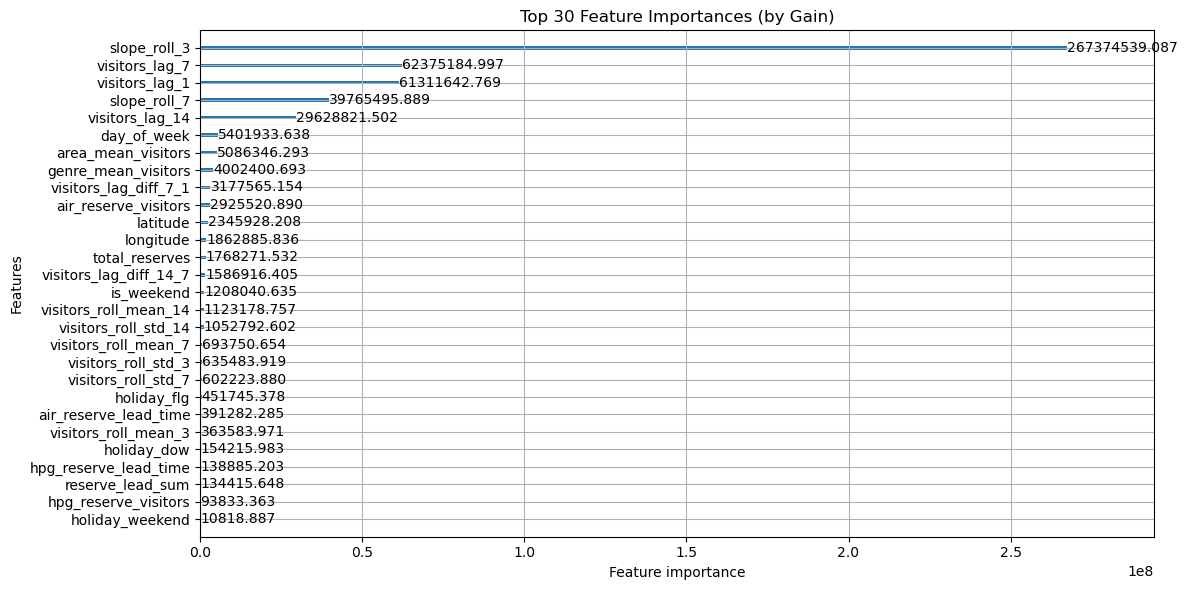

In [202]:
lgb.plot_importance(
    lgb_model,
    max_num_features=30,
    importance_type='gain',
    figsize=(12, 6)
)
plt.title("Top 30 Feature Importances (by Gain)")
plt.tight_layout()
plt.show()

In [203]:
results = []

for store_id in top_stores:
    try:
        store_prophet_df = full_df[full_df['air_store_id'] == store_id][['visit_date', 'visitors']].dropna()
        prophet_df = store_prophet_df.rename(columns={'visit_date': 'ds', 'visitors': 'y'})

        if len(prophet_df) < 30:
            continue

        m = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=True)
        m.fit(prophet_df)
        horizon = valid_df[valid_df['air_store_id'] == store_id]['visit_date'].nunique()
        future = m.make_future_dataframe(periods=horizon)
        forecast = m.predict(future)
        prophet_preds = forecast[['ds', 'yhat']].rename(columns={'ds': 'visit_date', 'yhat': 'prophet_pred'})

        store_valid = valid_df[valid_df['air_store_id'] == store_id].copy()
        store_valid['lgb_pred'] = lgb_model.predict(store_valid[features])
        merged = store_valid.merge(prophet_preds, on='visit_date', how='inner')

        y_true = merged['visitors']
        lgb_pred = np.clip(merged['lgb_pred'], 0, None)
        prophet_pred = np.clip(merged['prophet_pred'], 0, None)

        lgb_rmsle = np.sqrt(mean_squared_log_error(y_true, lgb_pred))
        prophet_rmsle = np.sqrt(mean_squared_log_error(y_true, prophet_pred))

        best_rmsle = float('inf')
        best_alpha = None
        for alpha in np.linspace(0, 1, 21):  # 0.00 to 1.00
            blend = alpha * lgb_pred + (1 - alpha) * prophet_pred
            rmsle = np.sqrt(mean_squared_log_error(y_true, blend))
            if rmsle < best_rmsle:
                best_rmsle = rmsle
                best_alpha = alpha

        if best_rmsle < lgb_rmsle:
            if best_alpha == 0.0:
                method = "prophet_only"
            elif best_alpha == 1.0:
                method = "lightgbm_only"
            else:
                method = "blend"
            final_rmsle = best_rmsle
        else:
            method = "lightgbm_only"
            final_rmsle = lgb_rmsle
            best_alpha = 1.0

        results.append({
            'store_id': store_id,
            'rmsle': final_rmsle,
            'method': method,
            'best_alpha': best_alpha,
            'lgb_rmsle': lgb_rmsle,
            'prophet_rmsle': prophet_rmsle
        })

        print(f"{store_id}: {method.upper()} → RMSLE: {final_rmsle:.4f} (α={best_alpha:.2f})")

    except Exception as e:
        print(f"Store {store_id} failed: {e}")

20:18:57 - cmdstanpy - INFO - Chain [1] start processing
20:18:57 - cmdstanpy - INFO - Chain [1] done processing
20:18:57 - cmdstanpy - INFO - Chain [1] start processing
20:18:57 - cmdstanpy - INFO - Chain [1] done processing
20:18:57 - cmdstanpy - INFO - Chain [1] start processing
20:18:57 - cmdstanpy - INFO - Chain [1] done processing


274: BLEND → RMSLE: 0.3482 (α=0.65)
161: BLEND → RMSLE: 0.1956 (α=0.75)


20:18:57 - cmdstanpy - INFO - Chain [1] start processing
20:18:58 - cmdstanpy - INFO - Chain [1] done processing
20:18:58 - cmdstanpy - INFO - Chain [1] start processing
20:18:58 - cmdstanpy - INFO - Chain [1] done processing


525: LIGHTGBM_ONLY → RMSLE: 0.3453 (α=1.00)
705: BLEND → RMSLE: 0.3007 (α=0.60)


20:18:58 - cmdstanpy - INFO - Chain [1] start processing
20:18:58 - cmdstanpy - INFO - Chain [1] done processing
20:18:58 - cmdstanpy - INFO - Chain [1] start processing
20:18:58 - cmdstanpy - INFO - Chain [1] done processing


290: BLEND → RMSLE: 0.2780 (α=0.90)
361: BLEND → RMSLE: 0.3203 (α=0.70)


20:18:58 - cmdstanpy - INFO - Chain [1] start processing
20:18:58 - cmdstanpy - INFO - Chain [1] done processing
20:18:58 - cmdstanpy - INFO - Chain [1] start processing


93: BLEND → RMSLE: 0.3242 (α=0.90)
385: BLEND → RMSLE: 0.2618 (α=0.70)


20:18:58 - cmdstanpy - INFO - Chain [1] done processing
20:18:58 - cmdstanpy - INFO - Chain [1] start processing
20:18:58 - cmdstanpy - INFO - Chain [1] done processing


429: BLEND → RMSLE: 0.2948 (α=0.65)
665: BLEND → RMSLE: 0.2181 (α=0.65)


In [204]:
results_df = pd.DataFrame(results).sort_values(by='rmsle')
print(results_df)
print(f"\nStores under 0.4 RMSLE: {(results_df['rmsle'] < 0.4).sum()} / {len(results_df)}")

   store_id     rmsle         method  best_alpha  lgb_rmsle  prophet_rmsle
1       161  0.195580          blend        0.75   0.212456       0.286899
9       665  0.218099          blend        0.65   0.275581       0.312892
7       385  0.261842          blend        0.70   0.284326       0.413798
4       290  0.277955          blend        0.90   0.280818       0.367913
8       429  0.294828          blend        0.65   0.325109       0.368327
3       705  0.300690          blend        0.60   0.329563       0.367849
5       361  0.320278          blend        0.70   0.337372       0.395601
6        93  0.324173          blend        0.90   0.325230       0.440659
2       525  0.345327  lightgbm_only        1.00   0.345327       0.509901
0       274  0.348153          blend        0.65   0.416838       0.446040

Stores under 0.4 RMSLE: 10 / 10
